In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode
from pathlib import Path
import cv2
import matplotlib as mpl
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [2]:
orm = ORM()
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV90', 'PV101', 'PV119', 'PV144']

In [3]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(Block, Block.id == Strike.block_id).join(Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18'
    ).all()

In [88]:
def analyze_db_data():
    df_ = []
    for strk, blk, exp in orm_res:
        miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
        df_.append({'strike_id': strk.id, 'time': strk.time, 'animal_id': exp.animal_id, 'miss_distance': miss_distance, 'pred_distance': strk.prediction_distance,
                  'movement_type': blk.movement_type, 'calc_speed': strk.calc_speed, 'proj_strike': strk.projected_strike_coords, 'bug_size': strk.bug_size,
                   'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0], 'is_hit': strk.is_hit, 'trial_id': strk.trial_id})

    df_ = pd.DataFrame(df_)
    df_['day'] = df_.time.dt.floor('d').copy()
    df_['trial_id'] = df_.trial_id.astype('Int32')
    df_['proj_strike_x'] = df_.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
    df_['proj_strike_y'] = df_.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
    df_['movement_type'] = df_.movement_type.replace({'low_horizontal': 'random_low_horizontal'})
    df_.drop(columns=['proj_strike'], inplace=True)

    for animal_id in df_.animal_id.unique():
        af_ = df_.query(f'animal_id=="{animal_id}"').sort_values(by='strike_id')
        first_day = af_.day.sort_values().iloc[0]
        df_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    df_.sort_values(by='time')
    return df_

df = analyze_db_data()
df.head()

,strike_id,time,animal_id,miss_distance,pred_distance,movement_type,calc_speed,bug_size,proj_bug_x,is_hit,trial_id,day,proj_strike_x,proj_strike_y,day_num
0,346,2023-05-16 18:34:46.391,PV91,83.999335,10.435168,circle,8.669997,100,-555.833111,False,1241,2023-05-16,7.180379,83.691878,3.0
1,1630,2023-06-19 14:30:39.000,PV91,75.709973,0.295611,random_low_horizontal,6.266883,100,-66.000000,False,2609,2023-06-19,-68.000000,16.000000,37.0
2,353,2023-05-17 10:27:26.154,PV91,68.920364,0.747611,circle,8.669004,100,-109.667132,False,1244,2023-05-17,-68.908235,-1.292953,4.0
3,356,2023-05-17 10:27:30.487,PV91,100.096845,6.864230,circle,8.649708,100,-448.245376,False,1244,2023-05-17,-78.923447,61.566776,4.0
4,359,2023-05-17 10:28:16.989,PV91,79.599906,9.250043,circle,8.668052,100,-538.662386,False,1246,2023-05-17,-38.908272,69.442720,4.0


In [5]:
PLT_COLORS = list(TABLEAU_COLORS.values()) + list(CSS4_COLORS.values())
COLORS = {
    'PV42': '#1f77b4',
    'PV85': '#ff7f0e',
    'PV91': '#2ca02c',
    'PV80': '#d62728',
    'PV97': '#9467bd',
    'PV88': '#8c564b'
}
PLT_COLORS = [c for c in PLT_COLORS if c not in COLORS.values()]
COLORS.update({
    aid: PLT_COLORS[i] for i, aid in enumerate([a for a in df.animal_id.unique() if a not in COLORS.keys()])
})
COLORS

{'PV42': '#1f77b4',
 'PV85': '#ff7f0e',
 'PV91': '#2ca02c',
 'PV80': '#d62728',
 'PV97': '#9467bd',
 'PV88': '#8c564b',
 'PV148': '#e377c2',
 'PV99': '#7f7f7f'}

## Strikes Dynamics

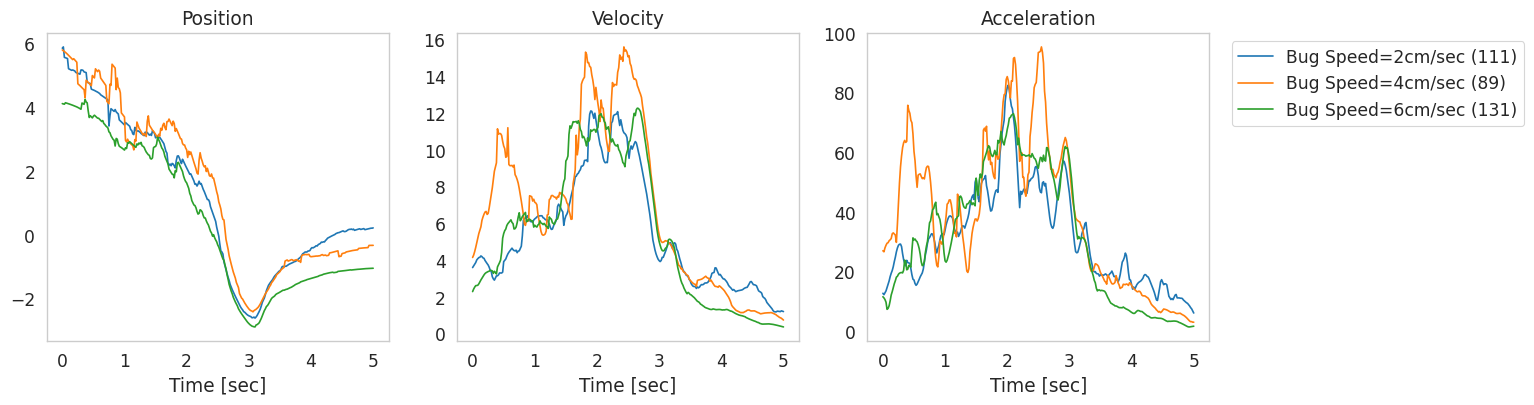

In [198]:
def plot_strikes_dynamics(movement_type, speeds=(2,4,6), animal_id=None):
    metrics = {'y': 'Position', 'velocity': 'Velocity', 'acceleration': 'Acceleration'}
    df_ = df.query(f'movement_type=="{movement_type}" and is_hit')
    if animal_id:
        df_ = df_.query(f'animal_id=="{animal_id}"')
    df_ = df_.reset_index(drop=True)
    res = {k: [] for k in speeds}

    for i, row in df_.iterrows():
        sid = row.strike_id
        try:
            speed = round(row.calc_speed)
            if speed % 2:
                speed -= 1
            if speed not in speeds:
                continue
            ld = Loader(int(sid), 'front', orm=orm, is_debug=False)
            sa = StrikeAnalyzer(ld)
            pf = sa.pose_df
            if pf is None or pf.empty:
                continue
            t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
            res[speed].append((t, *[pf[m].values for m in metrics.keys()]))
        except Exception:
            continue

    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    metrics_labels = list(metrics.keys())
    for metric, ax in zip(metrics_labels, axes):
        metric_id = metrics_labels.index(metric) + 1
        for i, speed in enumerate(speeds):
            lengths = [len(r[metric_id]) for r in res[speed]]
            mode_length = mode(lengths, keepdims=False).mode
            min_length = min([x for x in lengths if x > mode_length - 10])
            speed_res = [r for r in res[speed] if len(r[metric_id]) >= min_length]
            y = np.nanmean(np.vstack([r[metric_id][:min_length] for r in speed_res]), axis=0)
            t = speed_res[0][0][:min_length]
            ax.plot(t, y, label=f'Bug Speed={speed:.0f}cm/sec ({len(speed_res)})')
        if metric_id == len(metrics):
            ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        ax.set_title(metrics[metric])
        ax.grid(False)
        ax.set_xlabel('Time [sec]')

plot_strikes_dynamics('random_low_horizontal')

## Time to Feeder

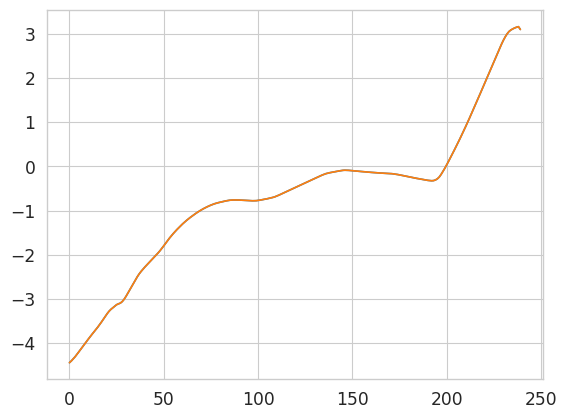

In [197]:
ld = Loader(397, 'front', orm=orm, sec_before=0, sec_after=30, is_debug=False)
ld.play_strike()
sa = StrikeAnalyzer(ld)
y = interpolate_y(sa.pose_df)
plt.plot(sa.pose_df.reset_index().y)
plt.plot(y)

In [188]:
from scipy import interpolate


def interpolate_y(pose_df, kind='quadratic'):
    nan_idx = pose_df.index[pose_df.y.isna()].tolist()
    no_nan_idx = pose_df.index[~pose_df.y.isna()].tolist()
    if len(no_nan_idx) == 0:
        return
    time = (pose_df.time - pose_df.time.iloc[0]).dt.total_seconds()
    intr = interpolate.interp1d(time.loc[no_nan_idx].values, pose_df.y.loc[no_nan_idx].values, kind=kind)
    inter_y = pose_df.y.copy()
    for i in nan_idx:
        try:
            inter_y.loc[i] = intr(time.loc[i])
        except Exception:
            continue
    return inter_y.values


def time_to_feeder(animal_ids=None, y_thresh=4):
    if animal_ids is None:
        animal_ids = df.animal_id.unique().tolist()
    else:
        animal_ids = [animal_ids] if isinstance(animal_ids, str) else animal_ids
    feeder_times_ = {}
    for animal_id in animal_ids:
        strikes_ids = df.query(f'animal_id=="{animal_id}" and is_hit').strike_id.values
        for sid in tqdm(strikes_ids, desc=animal_id):
            try:
                ld = Loader(int(sid), 'front', orm=orm, sec_before=0, sec_after=30, is_debug=False)
                sa = StrikeAnalyzer(ld)
                if all(sa.pose_df.y.isna()):
                    print(f'SID={sid} - All pose Y values are NaN')
                    continue
                y = interpolate_y(sa.pose_df)
                idx = y > y_thresh
                if not any(idx):
                    print(f'SID={sid} - No y coordinates above {y_thresh}')
                    continue
                t0 = sa.pose_df.time[idx].iloc[0]
                feeder_times_.setdefault(animal_id, []).append({'hit_time': sa.pose_df.time.iloc[0],
                                                                'time2feeder': (t0 - sa.pose_df.time.iloc[0]).total_seconds()})
            except Exception as exc:
                print(f'ERROR SID={sid}; {exc}')
        feeder_times_[animal_id] = pd.DataFrame(feeder_times_[animal_id])
    return feeder_times_


feeder_times = time_to_feeder()

PV91:   0%|          | 0/699 [00:00<?, ?it/s]

SID=397 - No y coordinates above 4
SID=105 - No y coordinates above 4
SID=124 - No y coordinates above 4
SID=135 - No y coordinates above 4
SID=137 - No y coordinates above 4
SID=156 - No y coordinates above 4
SID=158 - No y coordinates above 4
SID=159 - No y coordinates above 4
SID=161 - No y coordinates above 4
SID=162 - No y coordinates above 4
SID=163 - No y coordinates above 4
SID=167 - No y coordinates above 4
SID=171 - No y coordinates above 4
SID=179 - No y coordinates above 4
SID=180 - No y coordinates above 4
SID=190 - No y coordinates above 4
SID=160 - No y coordinates above 4
SID=168 - No y coordinates above 4
SID=196 - No y coordinates above 4
SID=200 - No y coordinates above 4
SID=214 - No y coordinates above 4
SID=210 - No y coordinates above 4
SID=347 - No y coordinates above 4
SID=412 - No y coordinates above 4
SID=430 - No y coordinates above 4
SID=435 - No y coordinates above 4
SID=452 - No y coordinates above 4
SID=469 - No y coordinates above 4
SID=474 - No y coord

PV97:   0%|          | 0/76 [00:00<?, ?it/s]

ERROR SID=2084; frames_df is empty after loading
SID=2086 - No y coordinates above 4
SID=2088 - No y coordinates above 4
ERROR SID=2077; frames_df is empty after loading
ERROR SID=2083; frames_df is empty after loading
SID=2091 - No y coordinates above 4
SID=2107 - All pose Y values are NaN
SID=2108 - All pose Y values are NaN
SID=2112 - No y coordinates above 4
SID=2113 - All pose Y values are NaN
SID=2114 - All pose Y values are NaN
SID=2116 - All pose Y values are NaN
SID=2123 - All pose Y values are NaN
SID=2125 - No y coordinates above 4
SID=2126 - All pose Y values are NaN
SID=2141 - All pose Y values are NaN
SID=2142 - No y coordinates above 4
SID=2143 - No y coordinates above 4
SID=2132 - No y coordinates above 4
SID=2135 - No y coordinates above 4
SID=2164 - No y coordinates above 4
SID=2171 - No y coordinates above 4
SID=2163 - No y coordinates above 4
SID=2169 - No y coordinates above 4
SID=2176 - No y coordinates above 4
SID=2177 - No y coordinates above 4
SID=2178 - No y c

PV88:   0%|          | 0/24 [00:00<?, ?it/s]

SID=2245 - No y coordinates above 4
SID=2250 - No y coordinates above 4
SID=2267 - No y coordinates above 4
SID=2268 - No y coordinates above 4


PV148:   0%|          | 0/32 [00:00<?, ?it/s]

SID=2308 - All pose Y values are NaN
SID=2314 - All pose Y values are NaN
SID=2315 - All pose Y values are NaN
SID=2324 - No y coordinates above 4
SID=2325 - All pose Y values are NaN
SID=2326 - All pose Y values are NaN
SID=2328 - All pose Y values are NaN
SID=2329 - No y coordinates above 4
SID=2330 - All pose Y values are NaN
SID=2327 - No y coordinates above 4
SID=2347 - All pose Y values are NaN
SID=2349 - All pose Y values are NaN
SID=2350 - No y coordinates above 4
SID=2351 - All pose Y values are NaN
SID=2336 - All pose Y values are NaN
SID=2338 - All pose Y values are NaN
SID=2370 - All pose Y values are NaN
SID=2371 - No y coordinates above 4
SID=2357 - All pose Y values are NaN
SID=2373 - No y coordinates above 4
SID=2374 - All pose Y values are NaN
SID=2375 - All pose Y values are NaN


PV99:   0%|          | 0/76 [00:00<?, ?it/s]

SID=2383 - All pose Y values are NaN
SID=2391 - All pose Y values are NaN
SID=2393 - No y coordinates above 4
SID=2405 - No y coordinates above 4
SID=2406 - All pose Y values are NaN
SID=2409 - All pose Y values are NaN
SID=2410 - All pose Y values are NaN
SID=2412 - No y coordinates above 4
SID=2414 - No y coordinates above 4
SID=2417 - No y coordinates above 4
SID=2418 - No y coordinates above 4
SID=2378 - No y coordinates above 4
SID=2379 - No y coordinates above 4
SID=2376 - No y coordinates above 4
SID=2390 - All pose Y values are NaN
SID=2394 - No y coordinates above 4
SID=2407 - All pose Y values are NaN
SID=2415 - No y coordinates above 4
SID=2419 - All pose Y values are NaN
SID=2442 - All pose Y values are NaN
SID=2450 - No y coordinates above 4
SID=2451 - No y coordinates above 4
SID=2454 - No y coordinates above 4
SID=2455 - No y coordinates above 4
SID=2457 - No y coordinates above 4
SID=2458 - All pose Y values are NaN
SID=2427 - All pose Y values are NaN
SID=2453 - No y c

In [187]:
time_to_feeder('PV99')

PV99:   0%|          | 0/76 [00:00<?, ?it/s]

SID=2383 - All pose Y values are NaN
SID=2391 - All pose Y values are NaN
SID=2393 - No y coordinates above 4
SID=2405 - No y coordinates above 4
SID=2406 - All pose Y values are NaN
SID=2409 - All pose Y values are NaN
SID=2410 - All pose Y values are NaN
SID=2412 - No y coordinates above 4
SID=2414 - No y coordinates above 4
SID=2417 - No y coordinates above 4
SID=2418 - No y coordinates above 4
SID=2378 - No y coordinates above 4
SID=2379 - No y coordinates above 4
SID=2376 - No y coordinates above 4
SID=2390 - All pose Y values are NaN
SID=2394 - No y coordinates above 4
SID=2407 - All pose Y values are NaN
SID=2415 - No y coordinates above 4
SID=2419 - All pose Y values are NaN
SID=2442 - All pose Y values are NaN
SID=2450 - No y coordinates above 4
SID=2451 - No y coordinates above 4
SID=2454 - No y coordinates above 4
SID=2455 - No y coordinates above 4
SID=2457 - No y coordinates above 4
SID=2458 - All pose Y values are NaN
SID=2427 - All pose Y values are NaN
SID=2453 - No y c

{'PV99':                         hit_time  time2feeder
 0  2023-07-12 09:34:19.755136000    22.632979
 1  2023-07-12 14:35:11.039747072     4.683259
 2  2023-07-12 15:35:16.716741120    13.633121
 3  2023-07-12 17:31:48.117008896     6.383234
 4  2023-07-12 08:33:38.928690944     5.899908
 5  2023-07-12 17:33:03.632496128     6.249902
 6  2023-07-13 10:31:07.650230016    27.682902
 7  2023-07-13 14:35:31.504438016     3.666608
 8  2023-07-13 14:31:08.875207936    13.266460
 9  2023-07-15 10:32:17.772173824    16.449744
 10 2023-07-15 12:30:37.677902848     4.949923
 11 2023-07-15 13:31:50.020522240     4.933255
 12 2023-07-15 14:34:15.811992832     3.399946
 13 2023-07-15 17:31:25.379236864     4.866590
 14 2023-07-15 12:31:36.726980096     3.283281
 15 2023-07-16 16:34:44.354656000     3.999937
 16 2023-07-16 08:30:41.858451968    12.133145
 17 2023-07-16 09:33:21.999699200    15.349759
 18 2023-07-16 10:34:35.475632896     4.799924
 19 2023-07-16 10:35:08.191788800    14.299776
 20 2

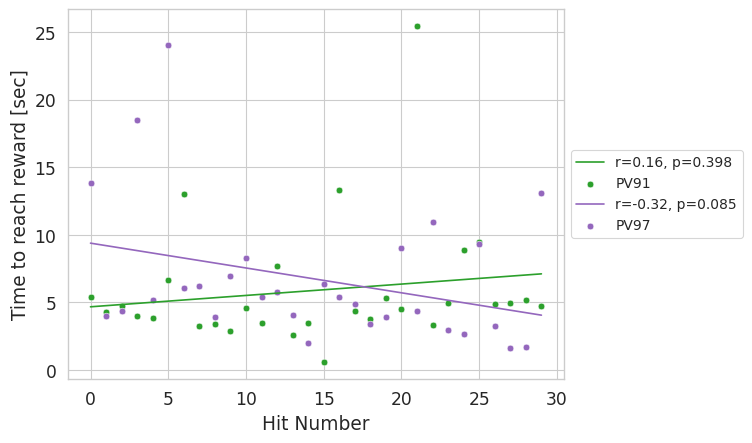

In [190]:
def plot_time2feeder(feeder_times_: dict, n_strikes=30):
    for animal_id, ft0 in feeder_times_.items():
        if len(ft0) < n_strikes:
            continue

        ft = ft0.copy().iloc[:n_strikes].reset_index()
        # ft = feeder_times_[animal_id].groupby([feeder_times_[animal_id]['hit_time'].dt.date]).mean().reset_index()
        # ft['days'] = (ft.hit_time - ft.hit_time.iloc[0]).dt.days
        # sns.regplot(data=ft, x='days', y='time2feeder', label=animal_id, color=COLORS[animal_id])
        plot_regression(plt.gca(), ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id])
        sns.scatterplot(data=ft, x='index', y='time2feeder', label=animal_id, color=COLORS[animal_id])
    plt.xlabel('Hit Number')
    plt.ylabel('Time to reach reward [sec]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)


plot_time2feeder(feeder_times)

In [163]:
for animal_id, ft_ in feeder_times.items():
    df_ = df.query(f"animal_id=='{animal_id}' and is_hit")
    print(f'{animal_id}: {len(ft_)}, {len(df_)}')

PV91: 383, 699
PV97: 18, 76
PV88: 1, 24
PV148: 1, 32
PV99: 7, 76


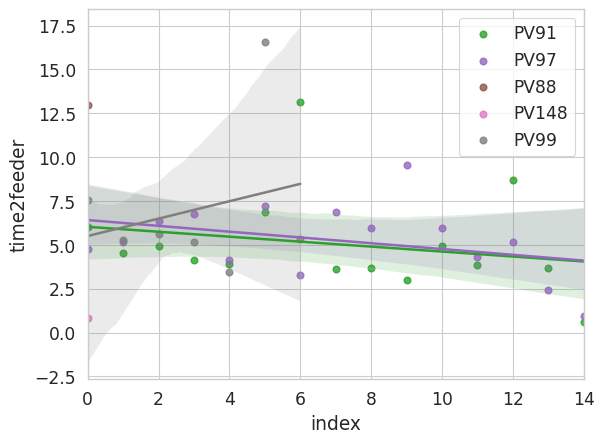

In [136]:
strikes2show = 15

for animal_id, ft0 in feeder_times.items():
    # ft = ft0.groupby([ft0['hit_time'].dt.date]).mean().reset_index()
    # ft['days'] = (ft.hit_time - ft.hit_time.iloc[0]).dt.days
    ft = ft0.iloc[:15].copy().reset_index()
    sns.regplot(data=ft, x='index', y='time2feeder', label=animal_id, color=COLORS[animal_id])

plt.legend()

In [129]:
feeder_times['PV91']

,hit_time,time2feeder
0,2023-05-18 09:55:41.220918016,5.999906
1,2023-05-18 09:56:42.619959040,4.516595
2,2023-05-19 11:21:10.446734848,4.949923
3,2023-05-19 14:31:40.701467904,4.149935
4,2023-05-19 16:32:06.521896960,3.899938
...,...,...
378,2023-06-25 08:32:02.341281024,2.933287
379,2023-06-25 15:31:44.881129984,3.166618
380,2023-06-25 10:31:20.229435904,3.683276
381,2023-06-25 11:31:20.773176832,3.499945


In [118]:
ft

,hit_time,time2feeder
0,2023-06-26,6.458232
1,2023-06-27,7.277663
2,2023-06-28,6.833228
3,2023-06-30,6.524897
4,2023-07-01,1.561086
5,2023-07-04,7.733212


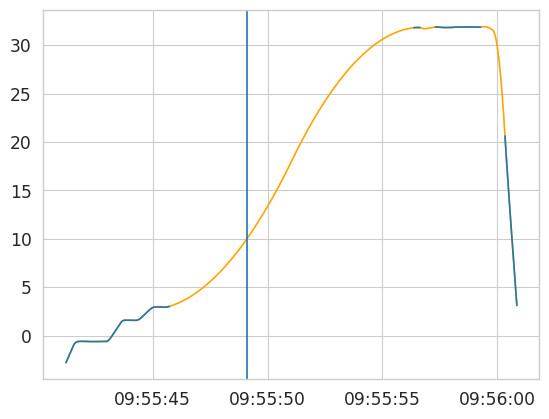

In [80]:
y_ = interpolate_y(pf)
t0 = pf.time[y_>10].iloc[0]

plt.plot(pf.time, interpolate_y(pf), color='orange')
plt.plot(pf.time, pf.y.values)
plt.axvline(t0)

In [83]:
(t0 - pf.time.iloc[0]).total_seconds()

7.883209

In [50]:
next(pf[['x', 'y']].items())

('x',
 1989    18.659394
 1990    18.628866
 1991    18.597555
 1992    18.566962
 1993    18.537514
           ...    
 3185          NaN
 3186          NaN
 3187          NaN
 3188          NaN
 3189          NaN
 Name: x, Length: 1201, dtype: float64)

## Engagement

In [9]:
def load_engagement():
    eng_ = []
    with orm.session() as s:
        exps = s.query(Experiment).filter(
            Experiment.arena.in_(['reptilearn4', 'msi-regev']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            Experiment.start_time > '2023-04-18').all()
        for exp in tqdm(exps):
            for blk in exp.blocks:
                # if blk.movement_type != 'random_low_horizontal':
                #     continue
                for tr in blk.trials:
                    trial_dict = {'trial_id': tr.id, 'animal_id': exp.animal_id, 'time': tr.start_time, 'is_strike': len(tr.strikes) > 0, 'block_id': blk.id, 'bug_speed': blk.bug_speed}
                    trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])
                    eng_.append(trial_dict)

    eng_ = pd.DataFrame(eng_)
    eng_['day'] = eng_.time.dt.floor('d').copy()
    for animal_id in eng_.animal_id.unique():
        af_ = eng_.query(f'animal_id=="{animal_id}"')
        first_day = af_.day.sort_values().iloc[0]
        eng_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    return eng_


eng = load_engagement()

  0%|          | 0/561 [00:00<?, ?it/s]

/tmp/ipykernel_1150042/2827526923.py:15: RuntimeWarning: Mean of empty slice
  trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])


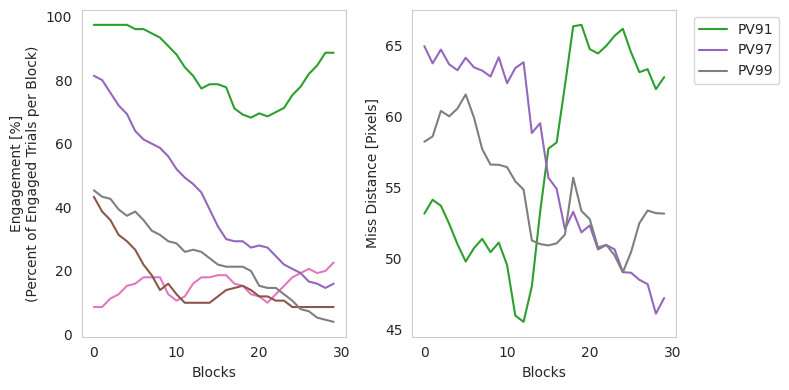

In [10]:
def plot_engagement(n_trials=30):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    g = eng.groupby(['animal_id', 'block_id']).is_strike.agg(['sum', 'count']).reset_index()
    g['engagement'] = (g['sum'] / g['count']) * 100
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['engagement'] = savgol_filter(g_.engagement, window_length=15, polyorder=0, mode='nearest')
        axes[0].plot(g_.index, g_['engagement'], label=animal_id, color=COLORS[animal_id])
    axes[0].grid(False)
    axes[0].set_xlabel('Blocks')
    axes[0].set_ylabel('Engagement [%]\n(Percent of Engaged Trials per Block)')

    g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'avg_miss': np.nanmean}).reset_index()
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['avg_miss'] = savgol_filter(g_.avg_miss, window_length=19, polyorder=0, mode='nearest')
        axes[1].plot(g_.index, g_['avg_miss'], label=animal_id, color=COLORS[animal_id])
    axes[1].grid(False)
    axes[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    axes[1].set_xlabel('Blocks')
    axes[1].set_ylabel('Miss Distance [Pixels]')
    plt.tight_layout()
    plt.show()


plot_engagement()

## Prediction Distance vs. Time in random_low_horizontal

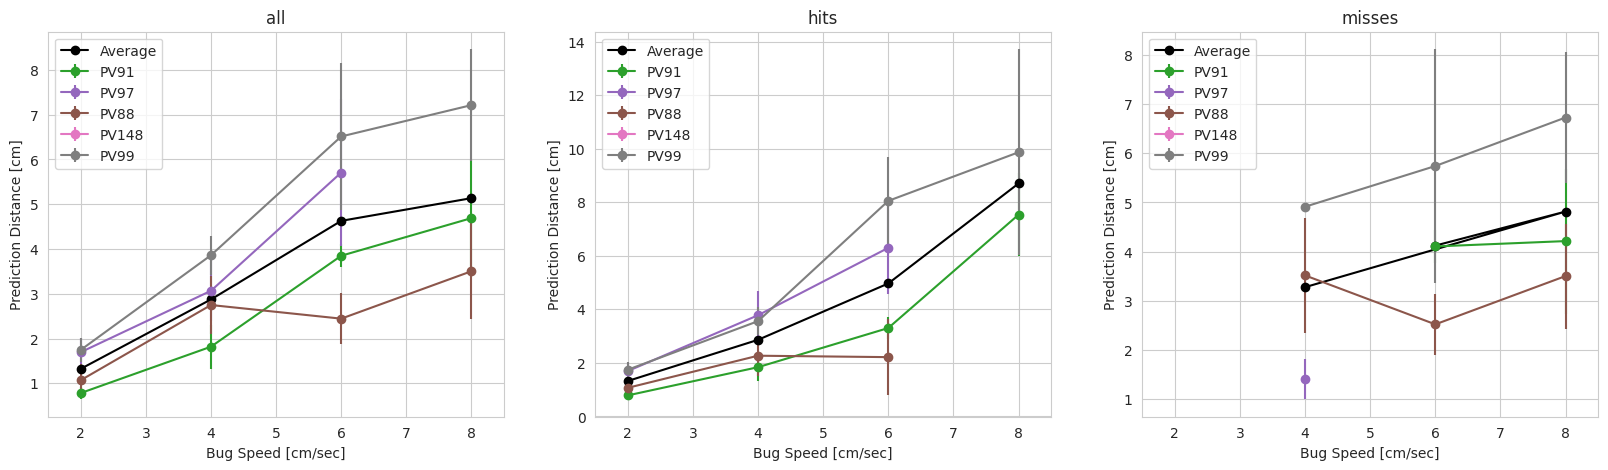

In [11]:
def plot_pred_distance(ax, movement_type, speeds=(2,4,6,8), labels_fontsize=None, hit_type='all'):
    assert hit_type in ['all', 'misses', 'hits']
    hit_type_query = ' and is_hit' if hit_type == 'hits' else ' and not is_hit' if hit_type == 'misses' else ''
    avg = []
    for animal_id in df.animal_id.unique():
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"{hit_type_query}')[['calc_speed', 'pred_distance']].copy()
        if af_.empty:
            continue
        af_['round_speed'] = af_.calc_speed.round()
        af_ = af_.query(f'round_speed in {speeds}').copy()
        g_ = af_.groupby('round_speed').pred_distance.agg(['mean', 'sem'])
        g_.dropna(inplace=True)
        avg.append(g_['mean'].to_dict())
        ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o')

    avg = pd.DataFrame(avg).mean()
    ax.plot(avg.index, avg.values, '-o', label='Average', color='k')
    ax.set_xlabel('Bug Speed [cm/sec]', fontsize=labels_fontsize)
    ax.set_ylabel('Prediction Distance [cm]', fontsize=labels_fontsize)
    ax.set_xlim([1.5, 8.5])
    ax.legend()


fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, hit_type_ in enumerate(['all', 'hits', 'misses']):
    plot_pred_distance(axes[i], 'random_low_horizontal', hit_type=hit_type_)
    axes[i].set_title(hit_type_)

## Miss Distance

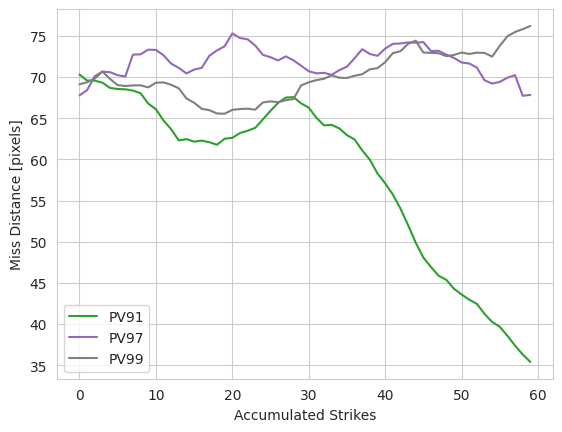

In [12]:
def plot_learning_curve(ax, movement_type, labels_fontsize=None, min_strikes=50):
    for animal_id in df.animal_id.unique():
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"').sort_values(by='strike_id').reset_index().copy()
        if af_.empty or (min_strikes and len(af_) < min_strikes):
            continue
        af_ = af_.iloc[:60]
        miss_distance = savgol_filter(af_.miss_distance, window_length=51, polyorder=0, mode='nearest')
        ax.plot(af_.index.tolist(), miss_distance, color=COLORS[animal_id], label=animal_id)
        # if af_.day_num.min() > 0:
        #     af_['day_num'] = af_.day_num - af_.day_num.min() 
        # g_ = af_.groupby('strike_num').miss_distance.agg(['mean', 'sem'])
        # g_['sem'].fillna(0, inplace=True)
        # ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o')
        # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

    ax.set_xlabel('Accumulated Strikes', fontsize=labels_fontsize)
    ax.set_ylabel('Miss Distance [pixels]', fontsize=labels_fontsize)
    ax.legend()


plot_learning_curve(plt.subplot(), 'random_low_horizontal', min_strikes=100)

## Projected Strikes

In [13]:
max_proj_x, max_proj_y = 300, 300

def plot_projected(ax, af):
    # af = af.query(f'-{max_proj_x} <= proj_bug_x <= {max_proj_x}')
    ax.add_patch(plt.Circle((0, 0), af.bug_size.mean(), color='lemonchiffon', alpha=0.5))
    
    cm = plt.cm.get_cmap('RdYlBu')
    cax = ax.inset_axes([0, 0, 0.5, 0.05])
    ax.axhline(0, linestyle='--', color='orange')
    sc = ax.scatter(af.proj_strike_x, af.proj_strike_y, c=af.proj_bug_x, cmap=cm)
    cbar = plt.colorbar(sc, ax=ax, cax=cax, orientation="horizontal")
    cbar.set_ticks([])
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])

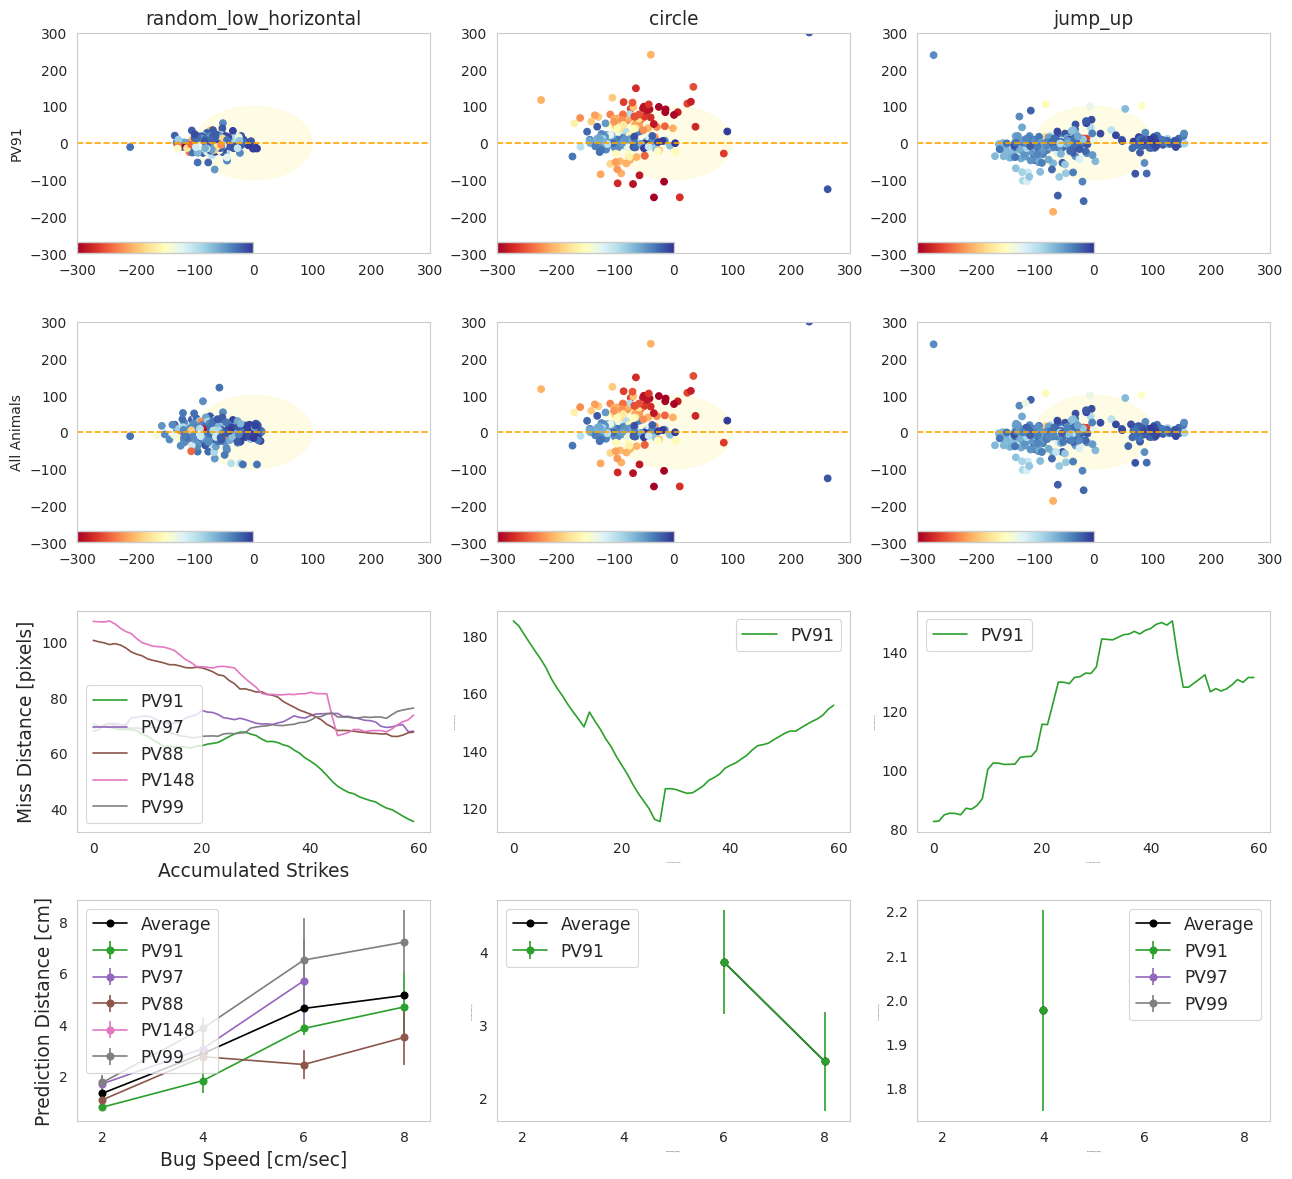

In [14]:
def plot_strikes_comparison():
    rows = 4
    fig, axes = plt.subplots(rows, 3, figsize=(13, 3*rows))
    sns.set_context('paper', font_scale=1.4)
    single_animal = 'PV91'
    for i, mt in enumerate(['random_low_horizontal', 'circle', 'jump_up']):
        # projected single animal
        af_ = df.query(f'animal_id=="{single_animal}" and movement_type=="{mt}"')
        plot_projected(axes[0, i], af_)
        axes[0, i].set_title(mt)
        if i == 0:
            axes[0, i].set_ylabel(single_animal)
        # projected all animals
        af_ = df.query(f'movement_type=="{mt}"')
        plot_projected(axes[1, i], af_)
        if i == 0:
            axes[1, i].set_ylabel('All Animals')
        # learning curves
        plot_learning_curve(axes[2, i], mt, labels_fontsize=None if i==0 else 0)
        plot_pred_distance(axes[3, i], mt, speeds=(2,4,6,8) if mt != 'jump_up' else (4,), labels_fontsize=None if i==0 else 0)
        for r in range(rows):
            axes[r, i].grid(False)

    fig.tight_layout()


plot_strikes_comparison()

## Jump Up

In [18]:
def get_time_from_prev_jump(strike_id):
    """return time in seconds from the closest jump before strike"""
    dt = np.nan
    try:
        ld = Loader(strike_id, 'front', is_load_pose=False, orm=orm)
        traj = ld.traj_df.copy()
        jump_idx = np.where(traj.y.diff().abs() > 40)[0]

        if len(jump_idx) > 0:
            jump_idx_ = jump_idx[jump_idx < ld.bug_traj_strike_id]
            if len(jump_idx_):
                closest_jump_before = jump_idx_[-1]
                dt = (ld.traj_df.time[ld.bug_traj_strike_id] - ld.traj_df.time[closest_jump_before]).total_seconds()
    except Exception as exc:
        print(f'Strike-{strike_id}: {exc}')
    return dt

Strike-1005: traj_df is empty
Strike-1007: traj_df is empty
Strike-1006: traj_df is empty
Strike-1051: traj_df is empty
Strike-1052: traj_df is empty
Strike-1068: traj_df is empty
Strike-1069: traj_df is empty
Strike-1071: traj_df is empty
Strike-1072: traj_df is empty
Strike-1073: traj_df is empty
Strike-1074: traj_df is empty
Strike-1070: traj_df is empty
Strike-1083: traj_df is empty
Strike-1230: traj_df is empty
Strike-1231: traj_df is empty
Strike-1233: traj_df is empty
Strike-1234: traj_df is empty
Strike-1235: traj_df is empty
Strike-1232: traj_df is empty


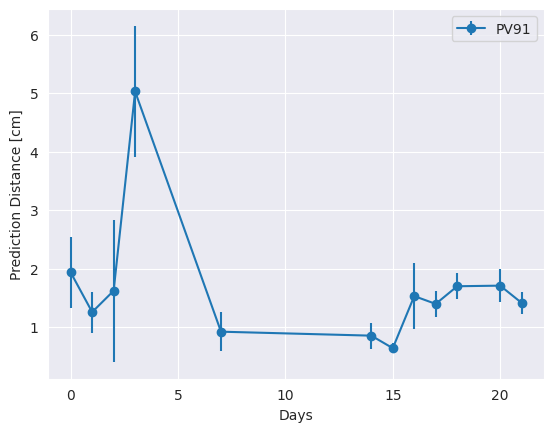

In [19]:
ax = plt.subplot()
for animal_id in df.animal_id.unique():
    if animal_id in ['PV80', 'PV85']:
        continue
    af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="jump_up"').copy()
    af_['time_from_jump'] = af_.strike_id.map(get_time_from_prev_jump)
    
    af_ = af_.query('0.005 <= time_from_jump <= 0.3')
    # af_.dropna(subset=['pred_distance'], inplace=True)
    # af_ = af_.sort_values(by='strike_id').reset_index()
    if af_.empty:
        continue
    # y = savgol_filter(af_.pred_distance, window_length=41, polyorder=0, mode='nearest')
    # ax.plot(af_.index, y, label=animal_id)
    
    if af_.day_num.min() > 0:
        af_['day_num'] = af_.day_num - af_.day_num.min()
    af_.dropna(subset=['pred_distance'], inplace=True)
    g_ = af_.groupby('day_num').pred_distance.agg(['mean', 'sem'])
    g_.dropna(inplace=True)
    ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], label=animal_id, fmt='-o', color=COLORS[animal_id])
    # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

ax.set_xlabel('Days')
ax.set_ylabel('Prediction Distance [cm]')
ax.legend()

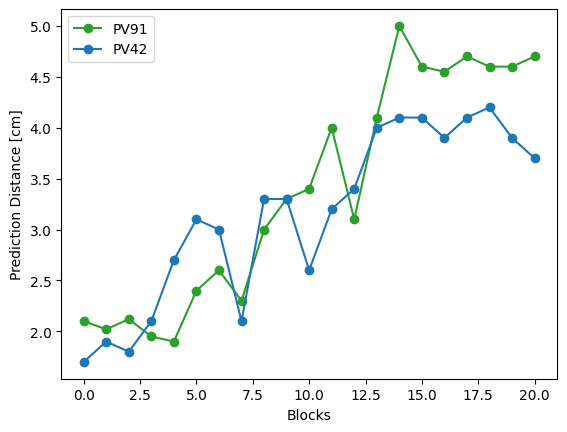

In [165]:
jumps = {
    'PV91': [2.1, 2.02, 2.12, 1.95, 1.9, 2.4, 2.6, 2.3, 3, 3.3, 3.4, 4, 3.1, 4.1, 5, 4.6, 4.55, 4.7, 4.6, 4.6, 4.7],
    'PV42': [1.7, 1.9, 1.8, 2.1, 2.7, 3.1, 3, 2.1, 3.3, 3.3, 2.6, 3.2, 3.4, 4, 4.1, 4.1, 3.9, 4.1, 4.2, 3.9, 3.7]
}

for animal_id, l in jumps.items():
    plt.plot(np.arange(len(l)), l, '-o', color=COLORS[animal_id], label=animal_id)

plt.xlabel('Blocks')
plt.ylabel('Prediction Distance [cm]')
plt.legend()

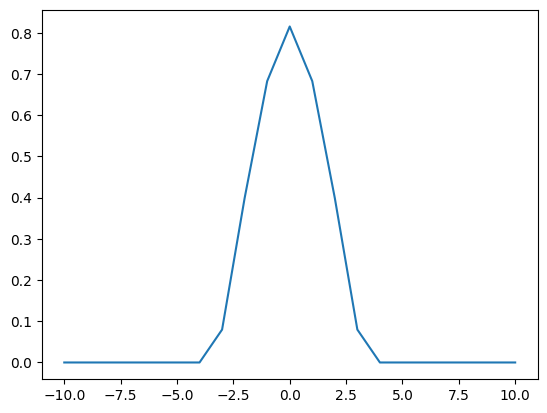

In [176]:
l = [(-10, 0),
(-9, 0),
(-8, 0),
(-7, 0),
(-6, 0),
(-5, 0),
(-4, 0),
(-3, 0.079788456),
(-2, 0.39894228),
(-1, 0.68268949),
(0, 0.81536437),
(1, 0.68268949),
(2, 0.39894228),
(3, 0.079788456),
(4, 0),
(5, 0),
(6, 0),
(7, 0),
(8, 0),
(9, 0),
(10, 0)
]
l = np.array(l)


plt.plot(l[:, 0], l[:, 1])

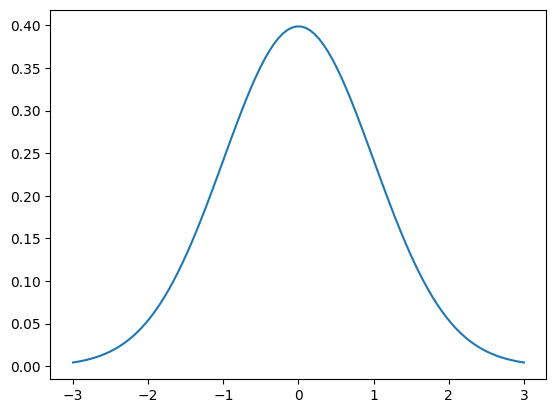

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

Text(0.5, 0, 'Horizontal Axis [cm]')

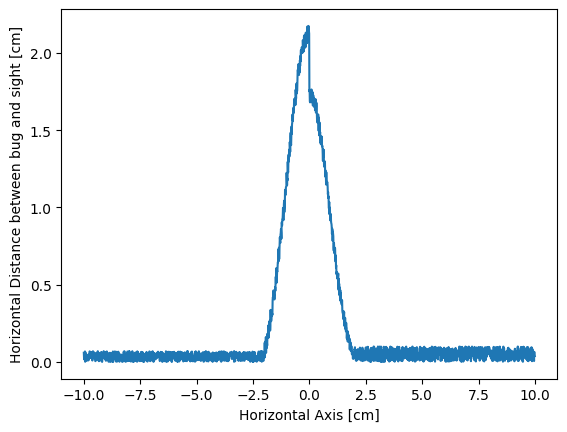

In [215]:
import random

x1 = np.arange(-10, -2, 0.01)
x2 = np.arange(-2, 2, 0.01)
x3 = np.arange(2, 10, 0.01)

y1 = np.zeros((len(x1),)) + 0.07 * np.array([random.random() for _ in range(len(x1))])
y3 = np.zeros((len(x3),)) + 0.1 * np.array([random.random() for _ in range(len(x3))])
y2 = stats.norm.pdf(x2, mu, sigma)
y2 = y2 - y2.min() + 0.02 * np.array([random.random() for _ in range(len(x2))])
y2[len(y2) // 2:] = y2[len(y2) // 2:] ** 1.2
y2 = y2 * 6
plt.plot(np.hstack([x1, x2, x3]), np.hstack([y1, y2, y3]))
plt.ylabel('Horizontal Distance between bug and sight [cm]')
plt.xlabel('Horizontal Axis [cm]')

In [178]:
stats.norm.pdf(x, mu, sigma) + random.random

array([0.00443185, 0.00530579, 0.00632878, 0.00752133, 0.00890582,
       0.0105065 , 0.01234943, 0.01446241, 0.01687483, 0.01961746,
       0.02272223, 0.02622189, 0.03014961, 0.03453857, 0.03942137,
       0.0448295 , 0.05079264, 0.05733801, 0.06448952, 0.07226707,
       0.08068571, 0.08975477, 0.09947714, 0.10984842, 0.12085626,
       0.13247967, 0.14468855, 0.15744319, 0.17069405, 0.18438164,
       0.1984366 , 0.21277993, 0.22732351, 0.24197072, 0.2566174 ,
       0.27115285, 0.28546117, 0.29942268, 0.31291556, 0.3258175 ,
       0.33800759, 0.34936814, 0.35978656, 0.36915722, 0.37738323,
       0.38437808, 0.3900672 , 0.39438923, 0.39729716, 0.39875915,
       0.39875915, 0.39729716, 0.39438923, 0.3900672 , 0.38437808,
       0.37738323, 0.36915722, 0.35978656, 0.34936814, 0.33800759,
       0.3258175 , 0.31291556, 0.29942268, 0.28546117, 0.27115285,
       0.2566174 , 0.24197072, 0.22732351, 0.21277993, 0.1984366 ,
       0.18438164, 0.17069405, 0.15744319, 0.14468855, 0.13247

In [14]:
ld = Loader(703, 'front', is_debug=False, orm=orm, sec_before=2, sec_after=6)

left_ear                 mid_ears                        nose  \
        cam_x cam_y      prob    cam_x cam_y      prob       cam_x   
1893      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1894      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1895      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1896      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1897      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
...       ...   ...       ...      ...   ...       ...         ...   
2369      NaN   NaN  0.000010      NaN   NaN  0.000071         NaN   
2370      NaN   NaN  0.000084      NaN   NaN  0.000050         NaN   
2371      NaN   NaN  0.000788      NaN   NaN  0.000570  870.688171   
2372      NaN   NaN  0.000011      NaN   NaN  0.000377         NaN   
2373      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   

                           right_ear  ...  vy  ax  ay      nose             \
           cam_y      prob     cam_x  ...                     x          y   
1893         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1894         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1895         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1896         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1897         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
...          ...       ...       ...  ...  ..  ..  ..       ...        ...   
2369         NaN  0.000031       NaN  ... NaN NaN NaN       NaN        NaN   
2370         NaN  0.071453       NaN  ... NaN NaN NaN       NaN        NaN   
2371  429.577515  0.923372       NaN  ... NaN NaN NaN  4.912532  14.547394   
2372         NaN  0.020929       NaN  ... NaN NaN NaN       NaN        NaN   
2373         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   

     left_ear     right_ear     angle  
            x   y         x   y        
1893      NaN NaN       NaN NaN   NaN  
1894      NaN NaN       NaN NaN   NaN  
1895      NaN NaN       NaN NaN   NaN  
1896      NaN NaN       NaN NaN   NaN  
1897      NaN NaN       NaN NaN   NaN  
...       ...  ..       ...  ..   ...  
2369      NaN NaN       NaN NaN   NaN  
2370      NaN NaN       NaN NaN   NaN  
2371      NaN NaN       NaN NaN   NaN  
2372      NaN NaN       NaN NaN   NaN  
2373      NaN NaN       NaN NaN   NaN  

[481 rows x 26 columns]

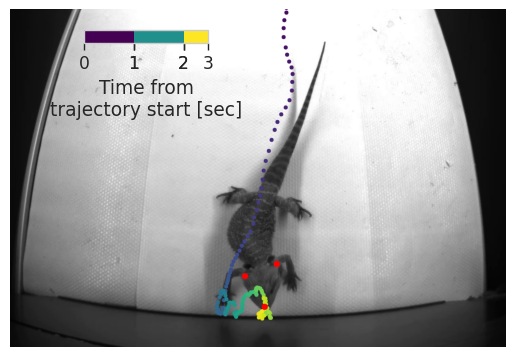

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ld = Loader(708, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=0)
xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
x = np.linspace(0, 1, len(xf))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(x)[:, :3] * 255).astype(int)
last_frame_id = xf.index[-2]
_, frame = next(ld.gen_frames([last_frame_id]))
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for i, row in xf.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[i, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = ld.frames_df[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

plt.figure()
frame = frame[100:, :]
plt.imshow(frame)
plt.grid(False)
plt.axis('off')
secs = (xf.index.values - xf.index[0]) / 60
bounds = [round(x) for x in secs[[round(i) for i in np.linspace(0, len(secs)-1, 6)]]]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# cbaxes = inset_axes(plt.gca(), width="30%", height="3%", loc='upper left')
cbaxes = plt.gca().inset_axes([0.15, 0.9, 0.25, 0.04])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', label='Time from\ntrajectory start [sec]',
             shrink=0.6, cax=cbaxes)

In [17]:
ld = Loader(708, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=20)
ld.play_strike(ld.n_frames_back, ld.n_frames_forward)

In [ ]:
for j in range(700, 750):
    ld = Loader(j, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=6)
    xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
    x = np.linspace(0, 1, len(xf))
    cmap_mat = (mpl.colormaps['viridis'](x)[np.newaxis, :, :3] * 255).astype(int).squeeze()
    last_frame_id = xf.index[-2]
    _, frame = next(ld.gen_frames([last_frame_id]))
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    for i, row in xf.reset_index(drop=True).iterrows():
        color = cmap_mat[i, :].tolist()
        frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 8, color, -1)

    plt.figure()
    plt.imshow(frame)
    plt.title(str(j))

In [59]:
cmap_mat

array([[ 68,   1,  84],
       [ 68,   1,  84],
       [ 68,   2,  85],
       [ 68,   3,  87],
       [ 69,   5,  88],
       [ 69,   5,  88],
       [ 69,   6,  90],
       [ 69,   8,  91],
       [ 70,   9,  92],
       [ 70,  11,  94],
       [ 70,  11,  94],
       [ 70,  12,  95],
       [ 70,  14,  97],
       [ 71,  15,  98],
       [ 71,  17,  99],
       [ 71,  17,  99],
       [ 71,  18, 101],
       [ 71,  20, 102],
       [ 71,  21, 103],
       [ 71,  22, 105],
       [ 71,  22, 105],
       [ 71,  24, 106],
       [ 72,  25, 107],
       [ 72,  26, 108],
       [ 72,  28, 110],
       [ 72,  28, 110],
       [ 72,  29, 111],
       [ 72,  30, 112],
       [ 72,  32, 113],
       [ 72,  33, 114],
       [ 72,  33, 114],
       [ 72,  34, 115],
       [ 72,  35, 116],
       [ 71,  37, 117],
       [ 71,  38, 118],
       [ 71,  38, 118],
       [ 71,  39, 119],
       [ 71,  40, 120],
       [ 71,  42, 121],
       [ 71,  43, 122],
       [ 71,  43, 122],
       [ 71,  44